In [1]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

# Exploring
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr

from env import hostname, user, password
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

import acquire as a





### <span style='color:#FE7D6A'>ACQUIRE

In [2]:
#full circle to make sure it works
sales_df =  a.get_store_data()

In [3]:
sales_df.head(3).T

store_id,1,1,1
item_id,1,1,1
sale_id,1,2,3
sale_date,2013-01-01,2013-01-02,2013-01-03
sale_amount,13,11,14
item_upc14,35200264013,35200264013,35200264013
item_upc12,35200264013,35200264013,35200264013
item_brand,Riceland,Riceland,Riceland
item_name,Riceland American Jazmine Rice,Riceland American Jazmine Rice,Riceland American Jazmine Rice
item_price,0.84,0.84,0.84
store_address,12125 Alamo Ranch Pkwy,12125 Alamo Ranch Pkwy,12125 Alamo Ranch Pkwy


In [4]:
sales_df.describe()

,item_id,sale_id,sale_amount,item_upc14,item_upc12,item_price,store_zipcode
count,10000.000000,10000.000000,10000.00000,1.000000e+04,1.000000e+04,10000.000000,10000.0
mean,3.261000,42157.774000,30.21510,1.960001e+11,1.960001e+11,3.425906,78253.0
std,1.594093,29041.368251,17.09331,2.750173e+11,2.750173e+11,2.065471,0.0
min,1.000000,1.000000,3.00000,1.111107e+10,1.111107e+10,0.840000,78253.0
25%,2.000000,18934.750000,17.00000,2.392333e+10,2.392333e+10,2.430000,78253.0
50%,3.000000,37868.500000,25.00000,3.520026e+10,3.520026e+10,2.610000,78253.0
75%,5.000000,73236.250000,40.00000,2.085288e+11,2.085288e+11,6.440000,78253.0
max,6.000000,92170.000000,115.00000,7.592831e+11,7.592831e+11,6.930000,78253.0


In [5]:
sales_df.shape

(10000, 13)

In [6]:
#Find Brands so we can compare or future time-series 
sales_df['item_brand'].unique()

array(['Riceland', 'Caress', 'Earths Best', 'Boars Head',
       'Back To Nature', 'Sally Hansen'], dtype=object)

In [9]:
#select columns to work with
sales_date = sales_df[[ 'sale_date', 'item_brand','sale_amount', 'item_price']].copy()


In [10]:
# get mi n and max for time-series
print('Date Range:', sales_date.sale_date.min(), 'to', sales_date.sale_date.max())
print('Shape:', sales_date.shape)

Date Range: 2013-01-01 to 2017-12-31
Shape: (10000, 4)


In [11]:
sales_date.head(3)

,sale_date,item_brand,sale_amount,item_price
store_id,,,,
1,2013-01-01,Riceland,13,0.84
1,2013-01-02,Riceland,11,0.84
1,2013-01-03,Riceland,14,0.84


In [12]:
# check to see what the types are 
sales_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 1
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sale_date    10000 non-null  object 
 1   item_brand   10000 non-null  object 
 2   sale_amount  10000 non-null  int64  
 3   item_price   10000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 390.6+ KB


In [13]:
#change sale_date from 'object' to "datetime'
sales_date['sale_date'] = pd.to_datetime(sales_date['sale_date'])


In [14]:
#check
sales_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 1
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sale_date    10000 non-null  datetime64[ns]
 1   item_brand   10000 non-null  object        
 2   sale_amount  10000 non-null  int64         
 3   item_price   10000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 390.6+ KB


In [15]:
#make sales date main index
sales_date.set_index('sale_date', inplace=True)


In [16]:
#check sales_date index timespan
sales_date.index.year

Int64Index([2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013,
            ...
            2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015],
           dtype='int64', name='sale_date', length=10000)

In [17]:
#check work
sales_date.head(2)

,item_brand,sale_amount,item_price
sale_date,,,
2013-01-01,Riceland,13,0.84
2013-01-02,Riceland,11,0.84


In [18]:
#make sure all brands are still there
sales_date['item_brand'].unique()

array(['Riceland', 'Caress', 'Earths Best', 'Boars Head',
       'Back To Nature', 'Sally Hansen'], dtype=object)

In [19]:
#check for nulls
null_values = sales_date.isnull()
null_values.head()

,item_brand,sale_amount,item_price
sale_date,,,
2013-01-01,False,False,False
2013-01-02,False,False,False
2013-01-03,False,False,False
2013-01-04,False,False,False
2013-01-05,False,False,False


In [20]:
null_values.any()

item_brand     False
sale_amount    False
item_price     False
dtype: bool

In [21]:
# Duplicates due to item brand by day
sales_date.duplicated()


sale_date
2013-01-01    False
2013-01-02    False
2013-01-03    False
2013-01-04     True
2013-01-05    False
              ...  
2015-05-16     True
2015-05-17     True
2015-05-18     True
2015-05-19     True
2015-05-20     True
Length: 10000, dtype: bool

In [22]:
sales_date.duplicated().any()

True

In [24]:
sales_date.duplicated().head()

sale_date
2013-01-01    False
2013-01-02    False
2013-01-03    False
2013-01-04     True
2013-01-05    False
dtype: bool

In [25]:
sales_date.tail()

,item_brand,sale_amount,item_price
sale_date,,,
2015-05-16,Sally Hansen,60,6.93
2015-05-17,Sally Hansen,86,6.93
2015-05-18,Sally Hansen,52,6.93
2015-05-19,Sally Hansen,72,6.93
2015-05-20,Sally Hansen,57,6.93


In [ ]:
#NOT REMOVING DUPLICATES DUE TO BRAND_ITEM COMPARISON
# # Check for duplicate values in the index of the sales_date DataFrame
# are_index_duplicates_present = sales_date.index.duplicated().any()

# if are_index_duplicates_present:
#     # Drop duplicate index values and reassign the cleaned index back to the DataFrame
#     sales_date = sales_date[~sales_date.index.duplicated()]
#     print("Duplicates in the index have been removed.")
# else:
#     print("No duplicates in the index to remove.")

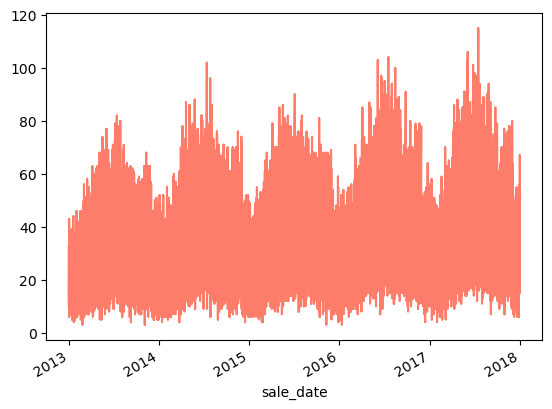

In [26]:
# sale amount by date
sales_date.sale_amount.plot(color='#FE7D6A')
plt.show()



In [27]:
brand_sale_df = sales_date.pivot_table(index='sale_date', columns='item_brand', values='sale_amount')
brand_sale_df.head()

item_brand,Back To Nature,Boars Head,Caress,Earths Best,Riceland,Sally Hansen
sale_date,,,,,,
2013-01-01,11.0,10.0,33.0,15.0,13.0,31.0
2013-01-02,6.0,11.0,43.0,30.0,11.0,36.0
2013-01-03,8.0,8.0,23.0,14.0,14.0,18.0
2013-01-04,9.0,19.0,18.0,10.0,13.0,19.0
2013-01-05,8.0,12.0,34.0,23.0,10.0,31.0


### <span style='color:#FE7D6A'>UPSAMPLING

In [28]:
# Sorting df by Daily 

# Sort the DataFrame by the index to handle duplicates
brand_sale_df.sort_index(inplace=True)

# Resample sales_date to daily frequency and use 'ffill' method to fill missing data
by_day = brand_sale_df.resample('D').ffill()

# Display the upsampled DataFrame
print(by_day.head())


item_brand  Back To Nature  Boars Head  Caress  Earths Best  Riceland  \
sale_date                                                               
2013-01-01            11.0        10.0    33.0         15.0      13.0   
2013-01-02             6.0        11.0    43.0         30.0      11.0   
2013-01-03             8.0         8.0    23.0         14.0      14.0   
2013-01-04             9.0        19.0    18.0         10.0      13.0   
2013-01-05             8.0        12.0    34.0         23.0      10.0   

item_brand  Sally Hansen  
sale_date                 
2013-01-01          31.0  
2013-01-02          36.0  
2013-01-03          18.0  
2013-01-04          19.0  
2013-01-05          31.0  


In [29]:
# Find missing values if any that were created during upsample

find_nulls =brand_sale_df.isnull()
find_nulls.head()

item_brand,Back To Nature,Boars Head,Caress,Earths Best,Riceland,Sally Hansen
sale_date,,,,,,
2013-01-01,False,False,False,False,False,False
2013-01-02,False,False,False,False,False,False
2013-01-03,False,False,False,False,False,False
2013-01-04,False,False,False,False,False,False
2013-01-05,False,False,False,False,False,False


In [30]:
#Resample sales_date by month
brand_sale_df.resample('M').sum()
brand_sale_df.head()


item_brand,Back To Nature,Boars Head,Caress,Earths Best,Riceland,Sally Hansen
sale_date,,,,,,
2013-01-01,11.0,10.0,33.0,15.0,13.0,31.0
2013-01-02,6.0,11.0,43.0,30.0,11.0,36.0
2013-01-03,8.0,8.0,23.0,14.0,14.0,18.0
2013-01-04,9.0,19.0,18.0,10.0,13.0,19.0
2013-01-05,8.0,12.0,34.0,23.0,10.0,31.0


Create data frame for brand_sales and sales_date 

In [31]:
frames = pd.concat([brand_sale_df, sales_date])
frames.tail().T

sale_date,2015-05-16,2015-05-17,2015-05-18,2015-05-19,2015-05-20
Back To Nature,NaN,NaN,NaN,NaN,NaN
Boars Head,NaN,NaN,NaN,NaN,NaN
Caress,NaN,NaN,NaN,NaN,NaN
Earths Best,NaN,NaN,NaN,NaN,NaN
Riceland,NaN,NaN,NaN,NaN,NaN
Sally Hansen,NaN,NaN,NaN,NaN,NaN
item_brand,Sally Hansen,Sally Hansen,Sally Hansen,Sally Hansen,Sally Hansen
sale_amount,60.0,86.0,52.0,72.0,57.0
item_price,6.93,6.93,6.93,6.93,6.93


In [32]:
frames.isnull().sum()

Back To Nature    10000
Boars Head        10000
Caress            10000
Earths Best       10000
Riceland          10000
Sally Hansen      10956
item_brand         1826
sale_amount        1826
item_price         1826
dtype: int64

In [33]:
brands_to_fill = ['Back To Nature', 'Boars Head', 'Caress', 'Earths Best', 'Riceland', 'Sally Hansen','item_brand']
means_to_fill = [ 'sale_amount', 'item_price']

# Fill missing values in the specified brands with 0 and missing values in other columns with mean
frames[brands_to_fill] = frames[brands_to_fill].fillna(0)
frames[means_to_fill] = frames[means_to_fill].fillna(frames[means_to_fill].mean())


# Display the DataFrame after filling missing values
frames.tail()



,Back To Nature,Boars Head,Caress,Earths Best,Riceland,Sally Hansen,item_brand,sale_amount,item_price
sale_date,,,,,,,,,
2015-05-16,0.0,0.0,0.0,0.0,0.0,0.0,Sally Hansen,60.0,6.93
2015-05-17,0.0,0.0,0.0,0.0,0.0,0.0,Sally Hansen,86.0,6.93
2015-05-18,0.0,0.0,0.0,0.0,0.0,0.0,Sally Hansen,52.0,6.93
2015-05-19,0.0,0.0,0.0,0.0,0.0,0.0,Sally Hansen,72.0,6.93
2015-05-20,0.0,0.0,0.0,0.0,0.0,0.0,Sally Hansen,57.0,6.93


In [34]:
frames.shape

(11826, 9)

In [35]:
frames.isnull().sum()

Back To Nature    0
Boars Head        0
Caress            0
Earths Best       0
Riceland          0
Sally Hansen      0
item_brand        0
sale_amount       0
item_price        0
dtype: int64

In [38]:
frames.head()

,Back To Nature,Boars Head,Caress,Earths Best,Riceland,Sally Hansen,item_brand,sale_amount,item_price
sale_date,,,,,,,,,
2013-01-01,11.0,10.0,33.0,15.0,13.0,31.0,0,30.2151,3.425906
2013-01-02,6.0,11.0,43.0,30.0,11.0,36.0,0,30.2151,3.425906
2013-01-03,8.0,8.0,23.0,14.0,14.0,18.0,0,30.2151,3.425906
2013-01-04,9.0,19.0,18.0,10.0,13.0,19.0,0,30.2151,3.425906
2013-01-05,8.0,12.0,34.0,23.0,10.0,31.0,0,30.2151,3.425906


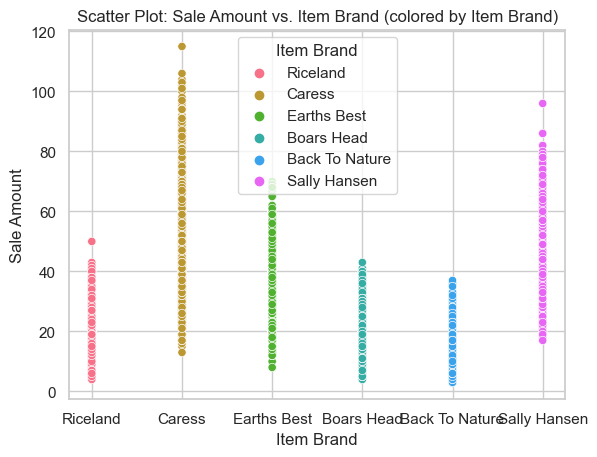

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame sales_date with columns 'sale_amount', 'item_brand', and other relevant columns

# Set the style and custom color palette
sns.set(style='whitegrid', palette=['#FE7D6A', '#F2B8C6'])

# Create the plot using seaborn's scatterplot
sns.scatterplot(x='item_brand', y='sale_amount', hue='item_brand', data=sales_date)

# Set labels and title
plt.xlabel('Item Brand')
plt.ylabel('Sale Amount')
plt.title('Scatter Plot: Sale Amount vs. Item Brand (colored by Item Brand)')

# Show the legend
plt.legend(title='Item Brand')

# Display the plot
plt.show()


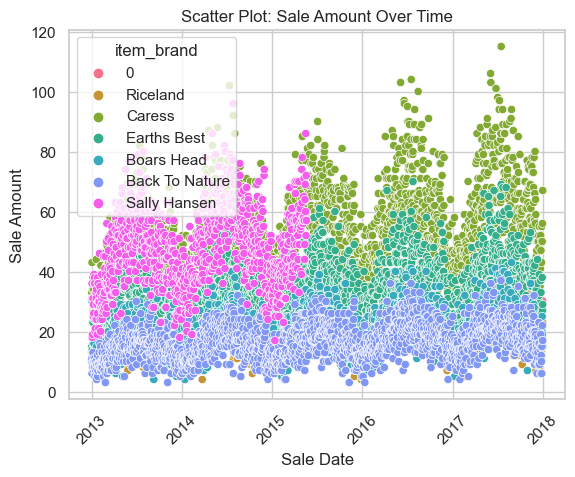

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame sales_date with columns 'sale_date' and 'sale_amount'

# Set the style and custom color palette
sns.set(style='whitegrid', palette=['#FE7D6A', '#F2B8C6'])

# Create the plot using seaborn's scatterplot
sns.scatterplot(x='sale_date', y='sale_amount', hue= 'item_brand',data=frames)

# Set labels and title
plt.xlabel('Sale Date')
plt.ylabel('Sale Amount')
plt.title('Scatter Plot: Sale Amount Over Time')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()


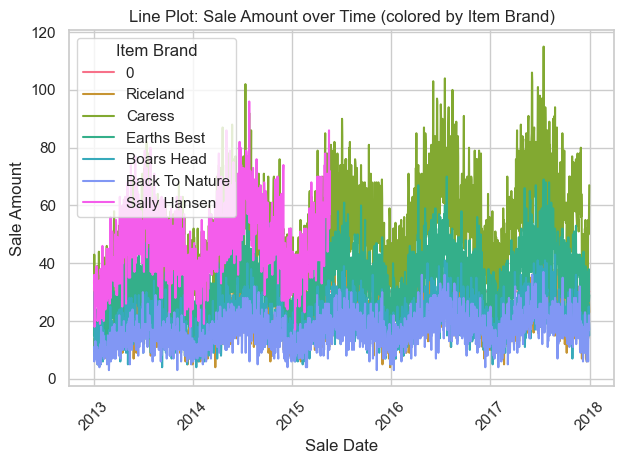

In [41]:
#Line Plot of Sale Date and Sale amount by item_brand

# Set the style and custom color palette
sns.set(style='whitegrid', palette=['#FE7D6A', '#F2B8C6'])

# Create the line plot using seaborn's lineplot
sns.lineplot(x='sale_date', y='sale_amount', hue='item_brand', data=frames)

# Set labels and title
plt.xlabel('Sale Date')
plt.ylabel('Sale Amount')
plt.title('Line Plot: Sale Amount over Time (colored by Item Brand)')

# Show the legend
plt.legend(title='Item Brand')

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


## Distribution plots of Sales Amount and Distribution Plot of Item Price

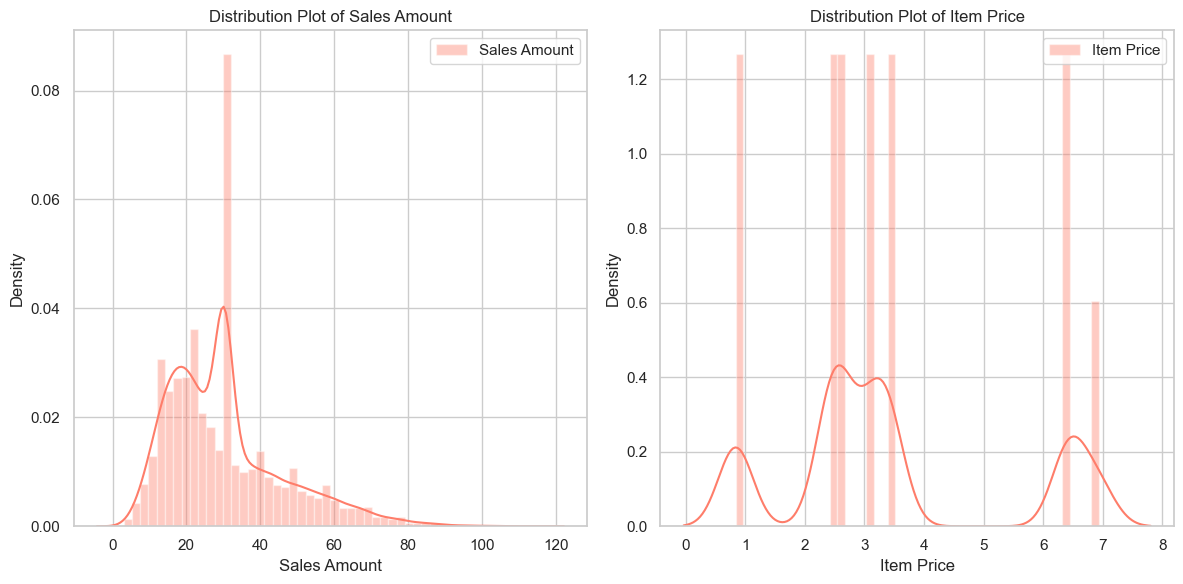

In [42]:

# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the distribution of sale_amount 
sns.distplot(frames['sale_amount'], label='Sales Amount', ax=axes[0])

# Plot the distribution of item_price 
sns.distplot(frames['item_price'], label='Item Price', ax=axes[1])

# Set labels and title for each subplot
axes[0].set_xlabel('Sales Amount')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution Plot of Sales Amount')

axes[1].set_xlabel('Item Price')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution Plot of Item Price')

# Show the legend for both subplots
axes[0].legend()
axes[1].legend()

# Adjust the layout to prevent overlapping of labels
plt.tight_layout()

# Display the plot
plt.show()

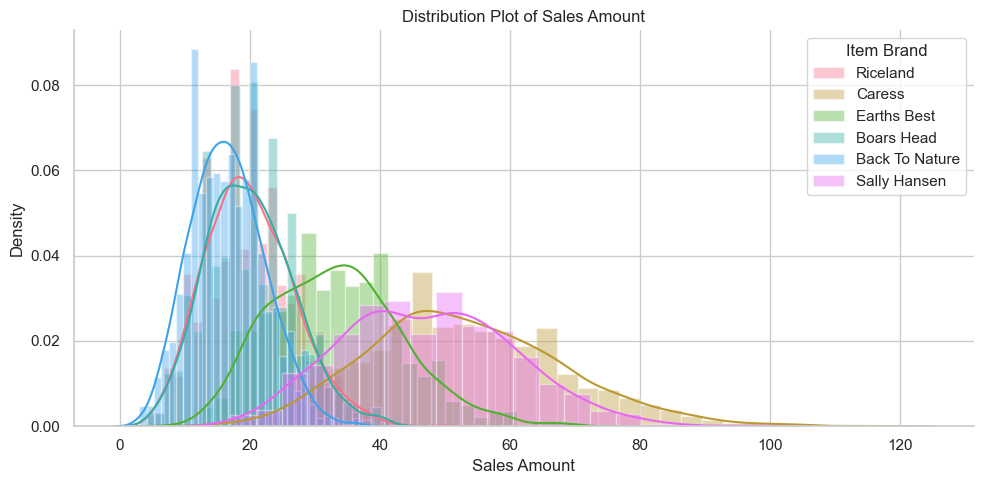

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style and custom color palette
sns.set(style='whitegrid', palette=['#FE7D6A', '#F2B8C6'])

# Create a 1x2 subplot grid
figsize=(12, 6)

# Plot the distribution of sale_amount for each item_brand
sns.FacetGrid(sales_df, hue='item_brand', height=5, aspect=2).map(sns.distplot, 'sale_amount')
plt.xlabel('Sales Amount')
plt.ylabel('Density')
plt.title('Distribution Plot of Sales Amount')
plt.legend(title='Item Brand')

# Adjust the layout to prevent overlapping of labels
plt.tight_layout()

# Display the plot
plt.show()


### <span style='color:#FE7D6A'>SPLIT DATA FOR TIME SERIES

In [45]:
def split_sale(df):
    '''Before sale must run: into 60%, 20% 20% adds prints the shape .'''
    df=sales_df
    train, sales_test = train_test_split(frames, test_size=0.2, random_state=42)
    sales_train, sales_validate = train_test_split(train, test_size=0.25, random_state=42) 
    print(f'Training set shape: {sales_train.shape}')
    print(f'Validation set shape: {sales_validate.shape}')
    print(f'Test set shape: {sales_test.shape}')
    return sales_train, sales_validate, sales_test

In [46]:
sales_train, sales_validate, sales_test = split_sale(frames)

Training set shape: (7095, 9)
Validation set shape: (2365, 9)
Test set shape: (2366, 9)


In [47]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7095 entries, 2014-04-23 to 2015-01-25
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Back To Nature  7095 non-null   float64
 1   Boars Head      7095 non-null   float64
 2   Caress          7095 non-null   float64
 3   Earths Best     7095 non-null   float64
 4   Riceland        7095 non-null   float64
 5   Sally Hansen    7095 non-null   float64
 6   item_brand      7095 non-null   object 
 7   sale_amount     7095 non-null   float64
 8   item_price      7095 non-null   float64
dtypes: float64(8), object(1)
memory usage: 554.3+ KB


In [62]:
sales_train.head(2)

,Back To Nature,Boars Head,Caress,Earths Best,Riceland,Sally Hansen,item_brand,sale_amount,item_price
sale_date,,,,,,,,,
2014-04-23,0.0,0.0,0.0,0.0,0.0,0.0,Earths Best,30.0000,2.430000
2017-05-20,32.0,33.0,89.0,54.0,34.0,0.0,0,30.2151,3.425906


In [ ]:
#check sales_date index timespan
sales_date.index.year

In [64]:
sales_df['sale_date'] = pd.to_datetime(sales_df['sale_date'])

# Set the 'date' column as the index
sales_df.set_index('sale_date', inplace=True)

# Now the index of the DataFrame will be in datetime format
print(sales_df.index.dtype)

datetime64[ns]


In [65]:
sales_train.index.min(), 'to', sales_train.index.max()

(Timestamp('2013-01-01 00:00:00'), 'to', Timestamp('2017-12-31 00:00:00'))

### <span style='color:#FE7D6A'> VISUAL DATA EXPLORATION

### Sale Amount  from 2013- 2017

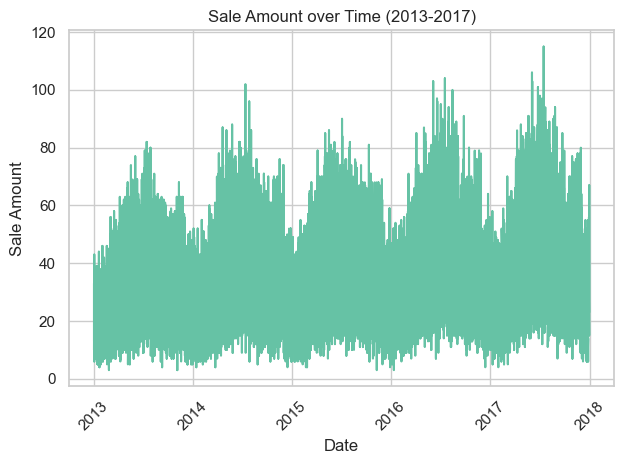

In [89]:
# Convert the date strings to datetime objects
start_date_train = pd.to_datetime('2013-01-01')
end_date_train = pd.to_datetime('2017-12-31')

# Ensure the index is unique and sorted in ascending order
sales_df = sales_df.sort_index()

# Select rows within the specified time range for training data
sales_train_human = sales_df.loc[start_date_train:end_date_train]

# Plot the 'sale_amount' for the selected training data
plt.plot(sales_train_human.index, sales_train_human['sale_amount'])

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Sale Amount')
plt.title('Sale Amount over Time (2013-2017)')

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


### Sale Amount Overtime based on Item Brand

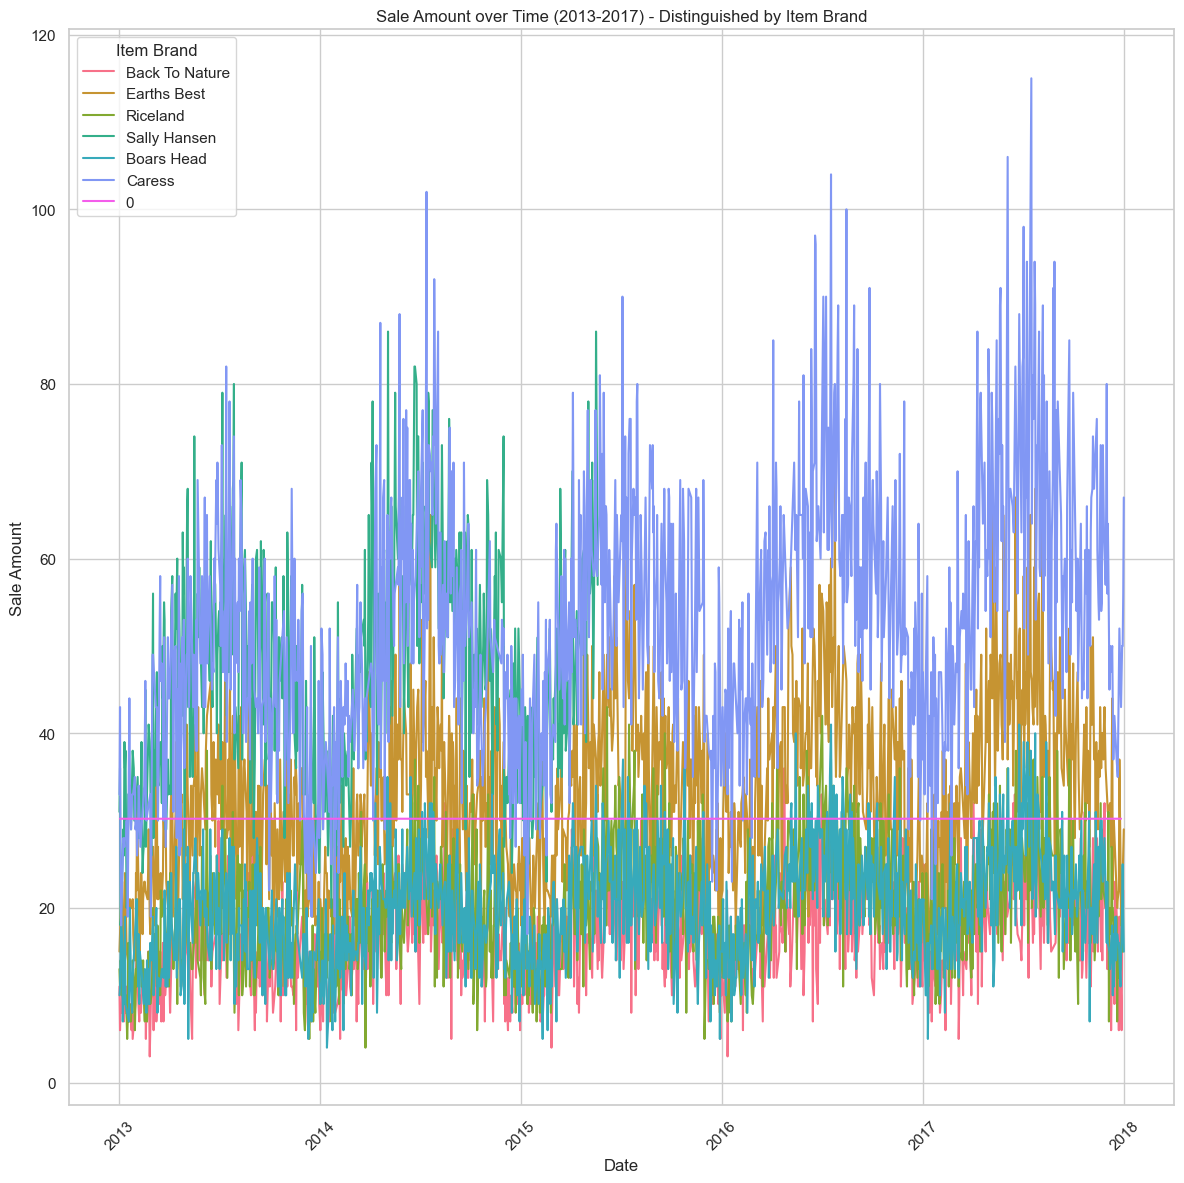

In [125]:

# Convert the date strings to datetime objects
start_date_train = pd.to_datetime('2013-01-01')
end_date_train = pd.to_datetime('2017-12-31')

# Ensure the index is unique and sorted in ascending order
sales_df = sales_df.sort_index()

# Select rows within the specified time range for training data
sales_train_human = sales_df.loc[start_date_train:end_date_train]

# Set the style and custom color palette
sns.set(style='whitegrid', palette=['#FE7D6A', '#F2B8C6'])

# Create the line plot using seaborn's lineplot with hue="item_brand"
sns.lineplot(x=sales_train_human.index, y='sale_amount', hue='item_brand', data=sales_train_human)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Sale Amount')
plt.title('Sale Amount over Time (2013-2017) - Distinguished by Item Brand')

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the legend
plt.legend(title='Item Brand')

# Adjust the layout to prevent overlapping of labels
plt.tight_layout()

# Display the plot
plt.show()


### Sale Amount Overtime based on Item Brand Visual Findings
Carress ended up witht he highes sales amount. Boars head and Back to Nature historically had lower sales. 

### Resampled Time Series: Total Sale Amount (Monthly Frequency)

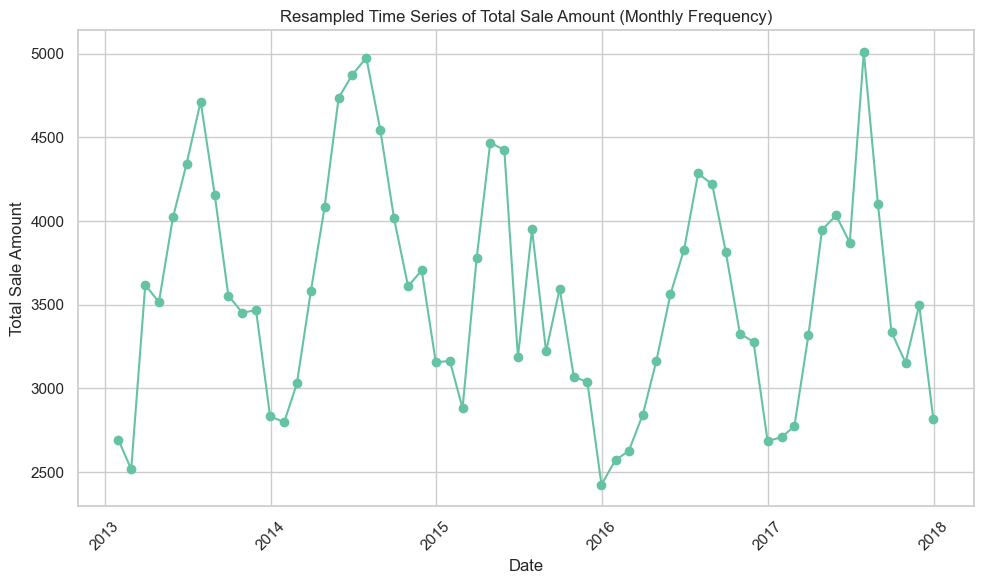

In [122]:
# Resample the data to monthly frequency and calculate the sum of 'sale_amount' for each item brand
monthly_sales_resampled = sales_train.resample('M').sum()

# Plot the resampled time series
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales_resampled.index, monthly_sales_resampled['sale_amount'], marker='o')
plt.xlabel('Date')
plt.ylabel('Total Sale Amount')
plt.title('Resampled Time Series of Total Sale Amount (Monthly Frequency)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



###  Total Sale Amount (Monthly Frequency) Visual Findings Line
July and August are biggest sales and Dec, Jan, Feb historically lower sales. Possibly people need more cleansers in Summer and less in Winter. Need to further investigate

### Resampled Time Series: Total Sale Amount (Monthly  Frequency) Bar

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


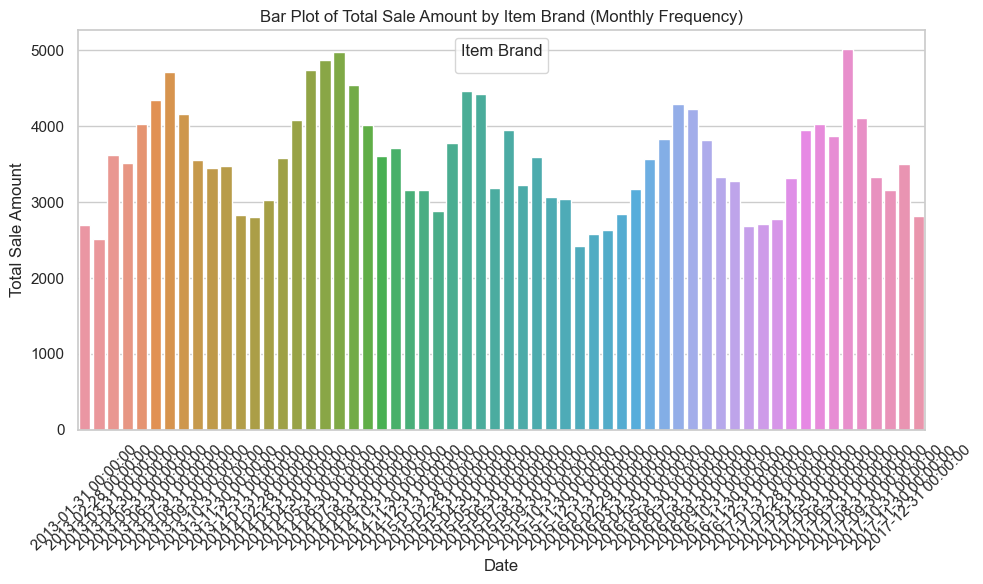

In [121]:

# Resample the data to monthly frequency and calculate the sum of 'sale_amount' for each item brand
monthly_sales_resampled = sales_train.resample('M').sum()

# Set the style and custom color palette
sns.set(style='whitegrid', palette='Set2')

# Create the bar plot with separate bars for each item brand
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_sales_resampled.index, y='sale_amount', data=monthly_sales_resampled)
plt.xlabel('Date')
plt.ylabel('Total Sale Amount')
plt.title('Bar Plot of Total Sale Amount by Item Brand (Monthly Frequency)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Item Brand')
plt.show()


### Total Sale Amount (Monthly Frequency) Visual findings  Bar
Another way to visualize that July and August are biggest sales and Dec, Jan, Feb historically lower sales. Possibly people need more cleansers in Summer and less in Winter. Need to further investigate

### Total Sale Amount (Yearly Frequency)  Bar

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


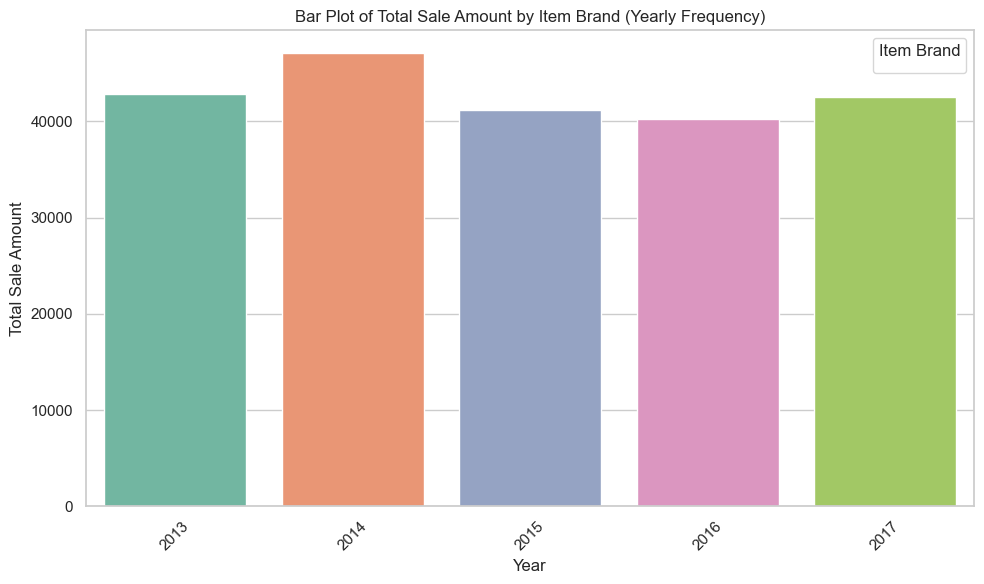

In [120]:
# Resample the data to yearly frequency and calculate the sum of 'sale_amount' for each item brand
yearly_sales_resampled = sales_train.resample('Y').sum()

# Set the style and custom color palette
sns.set(style='whitegrid', palette='Set2')

# Create the bar plot with separate bars for each item brand
plt.figure(figsize=(10, 6))
sns.barplot(x=yearly_sales_resampled.index.year, y='sale_amount', data=yearly_sales_resampled)
plt.xlabel('Year')
plt.ylabel('Total Sale Amount')
plt.title('Bar Plot of Total Sale Amount by Item Brand (Yearly Frequency)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Item Brand')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


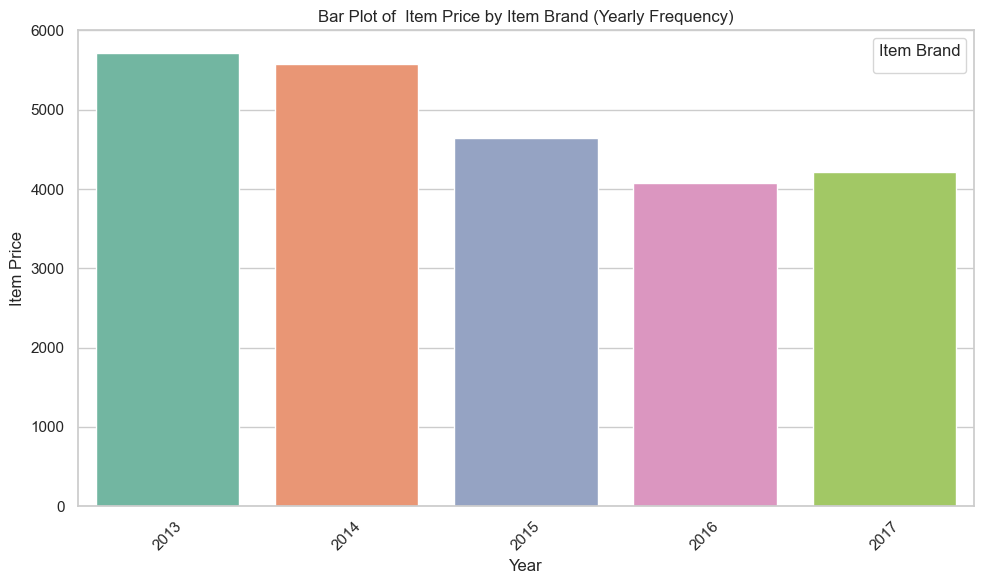

In [139]:
# Resample the data to yearly frequency and calculate the sum of 'sale_amount' for each item brand
yearly_sales_resampled = sales_train.resample('Y').sum()

# Set the style and custom color palette
sns.set(style='whitegrid', palette='Set2')

# Create the bar plot with separate bars for each item brand
plt.figure(figsize=(10, 6))
sns.barplot(x=yearly_sales_resampled.index.year, y='item_price', data=yearly_sales_resampled)
plt.xlabel('Year')
plt.ylabel('Item Price')
plt.title('Bar Plot of  Item Price by Item Brand (Yearly Frequency)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Item Brand')
plt.show()


### Total Sale Amount  and Item Price(Yearly Frequency) Visual findings  Bar
- 2014 was the highest performing year of sales and 2016 was the lowest performing year of sales
- Total Item price went down from 2013 to 2017

### Comparing Total Sale Amount and Item Price (Yearly Frequency)

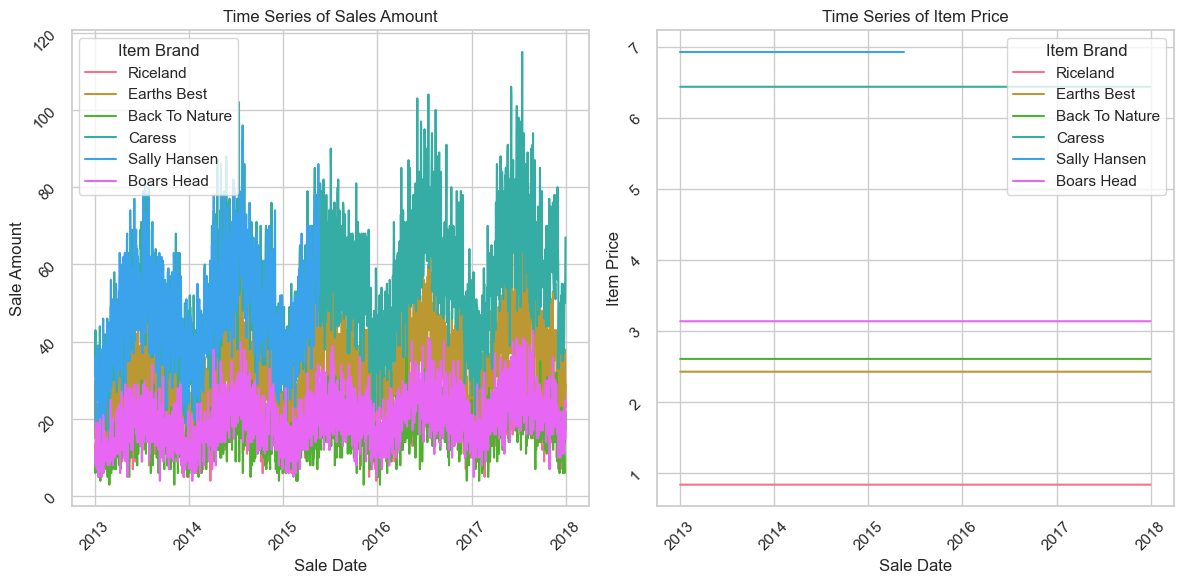

In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame sales_df with columns 'sale_date', 'sale_amount', and 'item_brand'

# Set the style and custom color palette
sns.set(style='whitegrid', palette=['#FE7D6A', '#F2B8C6'])

# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the time series of sale_amount for each item_brand
sns.lineplot(x='sale_date', y='sale_amount', hue='item_brand', data=sales_df, ax=axes[0])
axes[0].set_xlabel('Sale Date')
axes[0].set_ylabel('Sale Amount')
axes[0].set_title('Time Series of Sales Amount')
axes[0].legend(title='Item Brand')

# Plot the distribution of item_price for each item_brand
sns.lineplot(x='sale_date', y='item_price', hue='item_brand', data=sales_df, ax=axes[1])
axes[1].set_xlabel('Sale Date')
axes[1].set_ylabel('Item Price')
axes[1].set_title('Time Series of Item Price')
axes[1].legend(title='Item Brand')

# Rotate the x-axis labels for better readability (optional)
axes[0].tick_params(rotation=45)
axes[1].tick_params(rotation=45)

# Adjust the layout to prevent overlapping of labels
plt.tight_layout()

# Display the plot
plt.show()


### Total Sale Amount and Item Price (Yearly Frequency)
Item prices were consistnt through out the years and had minimal impact on sales price. WIth the exception of Caress, which sales prices increased during 2015

### Autocorrelation (Lag is number of time periods)

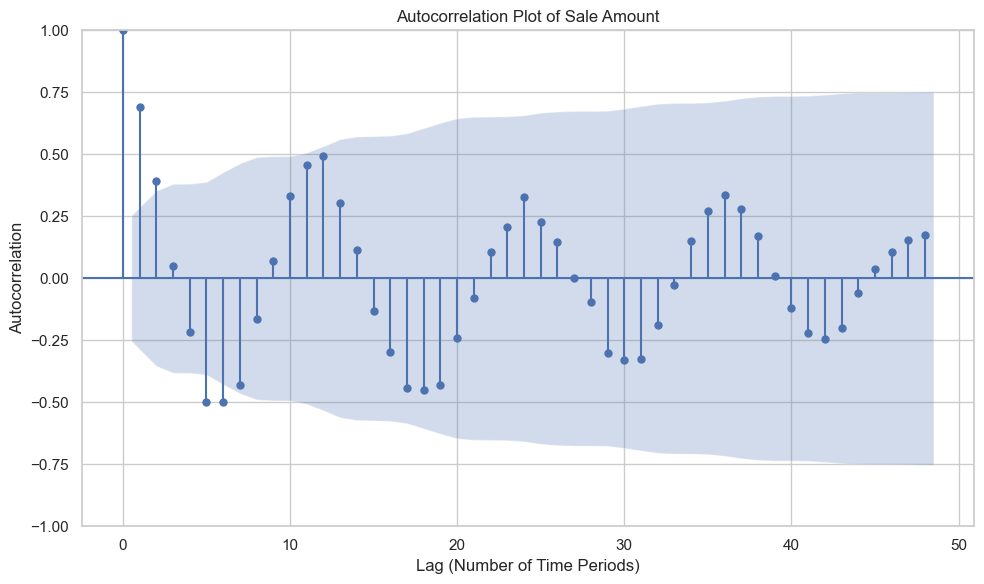

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Assuming you have a DataFrame sales_df with a datetime index and a 'sale_amount' column
# Convert the date strings to datetime objects
start_date_train = pd.to_datetime('2013-01-01')
end_date_train = pd.to_datetime('2017-12-31')

# Ensure the index is unique and sorted in ascending order
sales_df = sales_df.sort_index()

# Select rows within the specified time range for training data
sales_train_human = sales_df.loc[start_date_train:end_date_train]

# Set the style and custom color palette
sns.set(style='whitegrid', palette=['#4C72B0'])

# Create the autocorrelation plot for 'sale_amount'
plt.figure(figsize=(10, 6))
plot_acf(sales_train_human['sale_amount'], lags=48, alpha=0.05, ax=plt.gca())

# Set labels and title
plt.xlabel('Lag (Number of Time Periods)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot of Sale Amount')

# Display the plot
plt.tight_layout()
plt.show()


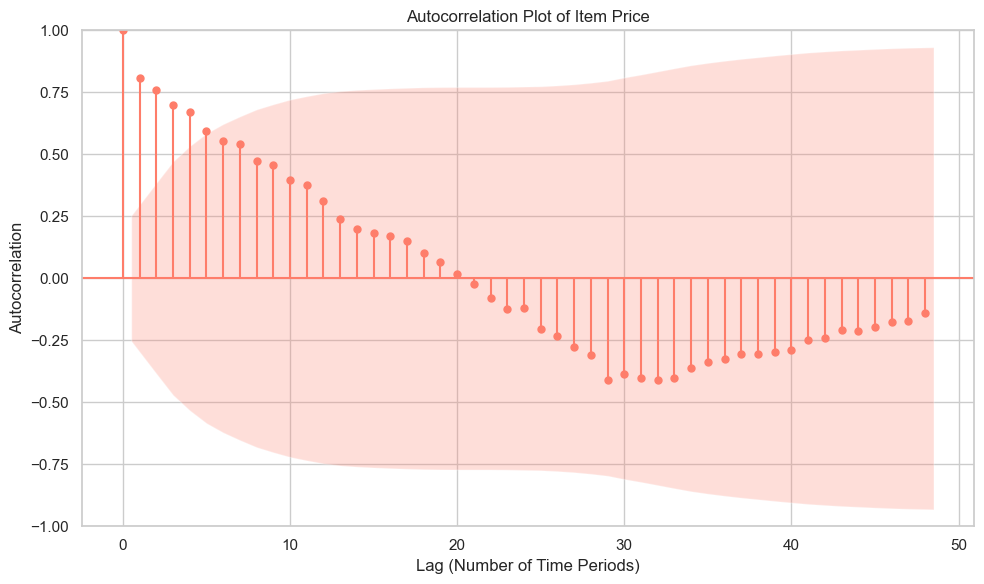

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Assuming you have a DataFrame sales_df with a datetime index and a 'sale_amount' column
# Convert the date strings to datetime objects
start_date_train = pd.to_datetime('2013-01-01')
end_date_train = pd.to_datetime('2017-12-31')

# Ensure the index is unique and sorted in ascending order
sales_df = sales_df.sort_index()

# Select rows within the specified time range for training data
sales_train_lag = sales_df.loc[start_date_train:end_date_train]

# Set the style and custom color palette
sns.set(style='whitegrid', palette=['#FE7D6A', '#F2B8C6'])

# Create the autocorrelation plot for 'sale_amount'
plt.figure(figsize=(10, 6))
plot_acf(sales_train_human['item_price'], lags=48, alpha=0.05, ax=plt.gca())

# Set labels and title
plt.xlabel('Lag (Number of Time Periods)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot of Item Price')

# Display the plot
plt.tight_layout()
plt.show()


### Autocorrelation (Sale amount by Weekly average)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

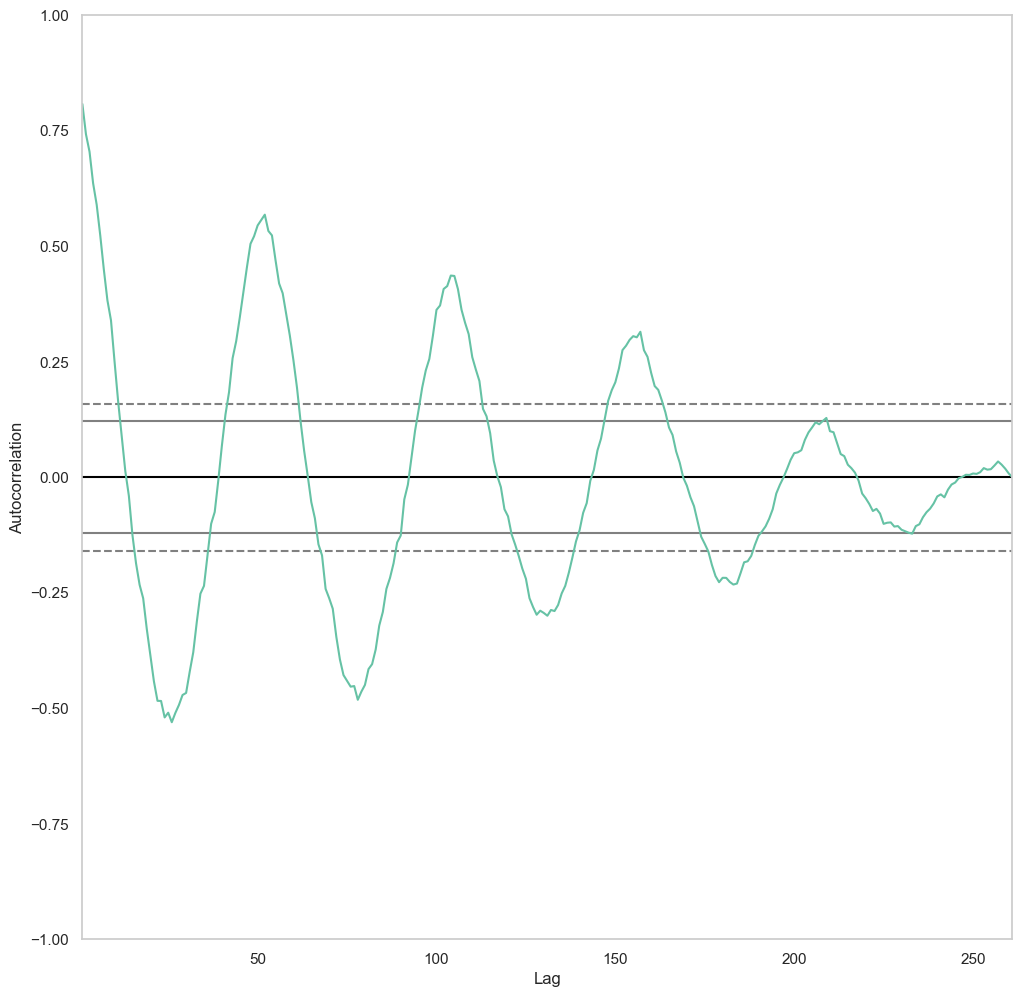

In [135]:
pd.plotting.autocorrelation_plot(sales_train.sale_amount.resample('W').mean())

### Autocorrelation (Item price by Weekly average)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

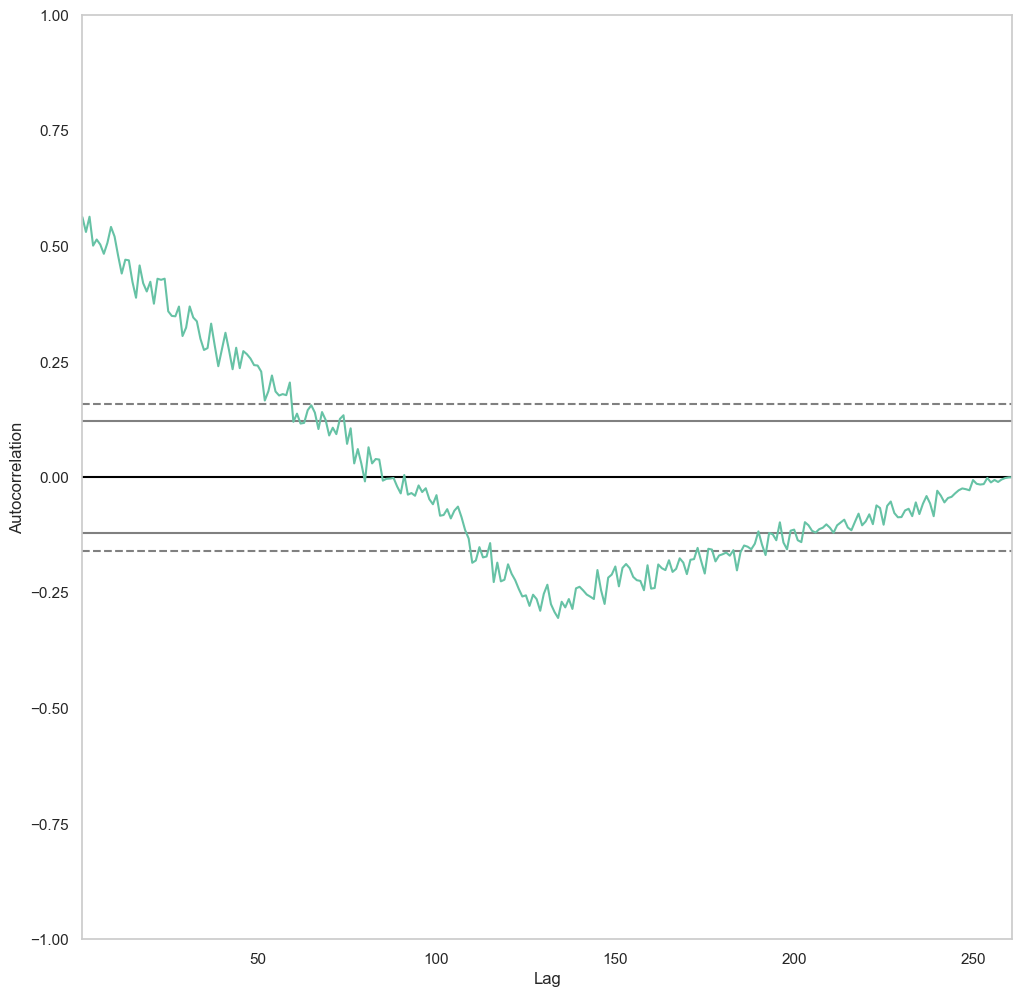

In [136]:
pd.plotting.autocorrelation_plot(sales_train.item_price.resample('W').mean())